## Retreat velocity processing + analysis

Using data formatted as STAC catalog in `retreat_stac_catalog.ipynb`.

In [1]:
import json
import pystac
import stackstac
import os
import xarray as xr
import geopandas as gpd
from shapely import Polygon
import matplotlib.pyplot as plt
import pandas as pd
import rioxarray as rio
from rasterio.crs import CRS
import rasterio 

In [2]:
crs = CRS.from_user_input('EPSG:32645')

## Utility fns

In [3]:
def get_footprint(ds):
    ''' returns a geopandas geodataframe with the outline of an xarray object.
    xr object must have crs formatted (ie ds.crs returns epsg code)
    '''
    
    left = ds.x.data.min()
    right = ds.x.data.max()
    bottom = ds.y.data.min()
    top = ds.y.data.max()

    bbox = [left, bottom, right, top]
    
    footprint = Polygon([
                [bbox[0], bbox[1]],
                [bbox[0], bbox[3]],
                [bbox[2], bbox[3]],
                [bbox[2], bbox[1]]
                ])
    
    gdf = gpd.GeoDataFrame(index=[0], crs = ds.crs, geometry = [footprint])
    
    return gdf
    
    

In [4]:
def make_bbox(gpdf):
    bounds = gpdf.total_bounds

    bbox = [
        (bounds[0], bounds[1]),
        (bounds[0], bounds[3]),
        (bounds[2], bounds[3]),
        (bounds[2], bounds[1])
        ]
    
    return bbox

In [10]:
def check_orig_files(item):
    
    file_ls = ['orig_file_dis_az', 'orig_file_dis_mag','orig_file_dis_N_ang','orig_file_dis_r']
    
    dt_ls, ref_date_ls, sec_date_ls = [],[],[]
    for file in file_ls:
        
        var_name_dt = f'{file}_datetime'
        var_name_ref = f'{file}_ref_date'
        var_name_sec = f'{file}_sec_date'
        
        var_name_dt = item.extra_fields[file][22:30]
        var_name_ref = item.extra_fields[file].split('+S1_')[1][:15]
        var_name_sec = item.extra_fields[file].split('+S1_')[1].split('_')[9]
        
        dt_ls.append(var_name_dt)
        ref_date_ls.append(var_name_ref)
        sec_date_ls.append(var_name_sec)
       
    if len(set(dt_ls)) != 1:
           print('issue w dt')
    elif len(set(ref_date_ls)) != 1:
             print('issue with ref date')
             
    elif len(set(sec_date_ls)) != 1:
             print('issue w sec date')

## Let's checkout the stac items to make sure its organized correctly...

In [5]:
catalog = pystac.Catalog.from_file('/home/emmamarshall/Desktop/phd_work/retreat/retreat/working_stac_catalog/catalog.json')
#items = list(cat.get_items())

In [6]:
catalog

"ID: RETREAT data, Langtang"
Description: OLD RETREAT velocity data for glaciers in Langtang region of Nepal/Tibet
type: Catalog
https://stac-extensions.github.io/projection/v1.0.0/schema.json
ID: 10_085_053_20210113
"Bounding Box: [83.90435612095534, 27.316552327766512, 86.84688658910103, 29.3949542892891]"
Datetime: 2021-01-13 00:00:00+00:00
tile: 10_085_053
sensor: S1
ref_date: 20210107T122220
ref_id: BFF8


In [8]:
items = list(catalog.get_items())

In [11]:
for item in items:
    
    check_orig_files(item)

In [12]:
feature_coll = [item.to_dict() for item in items]

In [13]:
gdf = gpd.GeoDataFrame.from_features(feature_coll)

<AxesSubplot: >

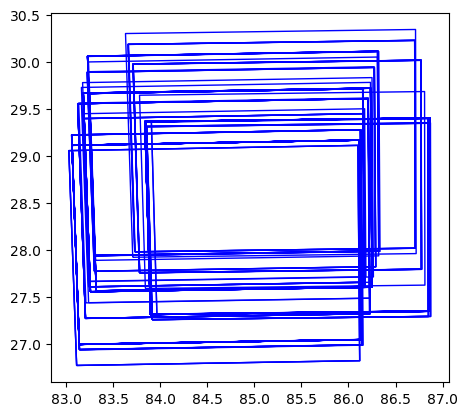

In [16]:
gdf.plot(facecolor='None', edgecolor='blue')

In [17]:
retreat = stackstac.stack(
    items = [item.to_dict() for item in items],
    epsg = '32645')


In [18]:
retreat

<xarray.DataArray 'stackstac-865099906d3f3a2d6ee7ed9804a33916' (time: 314,
                                                                band: 5,
                                                                y: 1951, x: 1875)>
dask.array<fetch_raster_window, shape=(314, 5, 1951, 1875), dtype=float64, chunksize=(1, 1, 1024, 1024), chunktype=numpy.ndarray>
Coordinates: (12/18)
  * time       (time) datetime64[ns] 2014-10-23 2014-10-31 ... 2021-11-05
    id         (time) <U19 '10_085_002_20141023' ... '10_019_085_20211105'
  * band       (band) <U9 'dis_ang' 'dis_az' 'dis_mag' 'dis_N_ang' 'dis_r'
  * x          (x) float64 1.128e+05 1.13e+05 1.132e+05 ... 4.874e+05 4.876e+05
  * y          (y) float64 3.357e+06 3.357e+06 3.357e+06 ... 2.967e+06 2.967e+06
    frame      (time) <U3 '085' '019' '019' '085' ... '019' '019' '019' '019'
    ...         ...
    sec_id     (time) <U4 'D1BD' '1CFB' '3910' 'C64F' ... 'F61C' 'D582' '3830'
    tile       (time) <U10 '10_085_002' '10_019_001' ... '10_019_085'
    orig_file  (time) <U219 '/home/emmamarshall/Desktop/phd_work/retreat/data...
    proj:epsg  int64 32645
    title      (band) <U9 'dis_ang' 'dis_az' 'dis_mag' 'dis_N_ang' 'dis_r'
    epsg       <U5 '32645'
Attributes:
    spec:        RasterSpec(epsg='32645', bounds=(112800.0, 2966800.0, 487800...
    crs:         epsg:32645
    transform:   | 200.00, 0.00, 112800.00|\n| 0.00,-200.00, 3357000.00|\n| 0...
    resolution:  200.0

## Read in RGI data

In [23]:
rgi_path = '/home/emmamarshall/Desktop/data/rgi/south_asia_east_15/'

In [24]:
rgi15 = gpd.read_file(os.path.join(rgi_path,'15_rgi60_SouthAsiaEast.shp'))

In [25]:
rgi15_prj = rgi15.to_crs('EPSG:32645')

### Subset RGI dataframe
- only want the 32 glaciers from original study

In [26]:
rgi_ids = pd.read_csv('/home/emmamarshall/Desktop/phd_work/retreat/manuscript_edits/manuscript_rgi_ids.csv', )

In [27]:
rgi_ids.head()

,RGI_IDs
0,RGI60-15.10255
1,RGI60-15.10285
2,RGI60-15.10279
3,RGI60-15.10286
4,RGI60-15.03976


In [28]:
rgi_subset = rgi15_prj.loc[rgi15_prj['RGIId'].isin(rgi_ids['RGI_IDs'])]

In [29]:
rgi_subset.head()

,RGIId,GLIMSId,BgnDate,EndDate,CenLon,CenLat,O1Region,O2Region,Area,Zmin,...,Aspect,Lmax,Status,Connect,Form,TermType,Surging,Linkages,Name,geometry
108,RGI60-15.03976,G085055E28346N,20001122,-9999999,85.054817,28.345892,15,1,6.686,4598,...,306,4052,0,0,0,0,9,9,NaN,"POLYGON ((308663.373 3137982.851, 308663.373 3..."
117,RGI60-15.04119,G085645E28262N,20010922,-9999999,85.644977,28.262351,15,1,11.836,4179,...,193,12856,0,0,0,0,9,9,NaN,"POLYGON ((369296.684 3130867.436, 369311.555 3..."
118,RGI60-15.04121,G085670E28312N,20010922,-9999999,85.669846,28.312454,15,1,37.792,4505,...,172,18899,0,0,0,0,9,9,NaN,"POLYGON ((373193.745 3139566.043, 373207.593 3..."
122,RGI60-15.04176,G085747E28200N,20011227,-9999999,85.747482,28.200093,15,1,10.284,4543,...,244,10547,0,0,0,0,9,9,NaN,"POLYGON ((378553.104 3121654.077, 378507.266 3..."
123,RGI60-15.04220,G085725E28163N,20011227,-9999999,85.724648,28.163227,15,2,7.703,4393,...,213,6646,0,0,0,0,9,9,NaN,"POLYGON ((374611.046 3117152.013, 374620.004 3..."


In [35]:
gdf = gdf.set_crs('EPSG:4326')

In [36]:
gdf_prj = gdf.to_crs('EPSG:32645')

<AxesSubplot: >

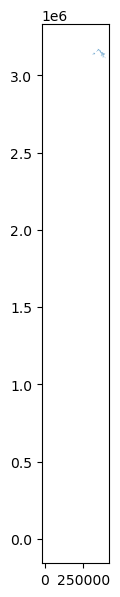

In [30]:
fig, ax = plt.subplots(figsize=(7,7))

#retreat_footprint.plot(ax=ax, facecolor='None', edgecolor='blue')
rgi_subset.plot(ax=ax)
gdf.plot(facecolor='None', edgecolor='blue', ax=ax)

In [ ]:
#retreat.isel(time=0).sel(band='dis_mag').spatial_ref.attrs['crs_wkt']

## Ind glacier workflow to start

In [28]:
rgi_03976 = rgi_subset.loc[rgi_subset['RGIId'] == 'RGI60-15.03976']

In [69]:
cube_03976 = cube.rio.clip(rgi1.geometry, rgi1.crs)

In [70]:
cube_03976

<xarray.DataArray 'stackstac-59192bed66f9de83001d7bb4304b2f6f' (time: 314,
                                                                band: 5, y: 19,
                                                                x: 15)>
dask.array<getitem, shape=(314, 5, 19, 15), dtype=float64, chunksize=(1, 1, 19, 15), chunktype=numpy.ndarray>
Coordinates: (12/19)
  * time         (time) datetime64[ns] 2014-10-23 2014-10-31 ... 2021-11-05
    id           (time) <U19 '10_085_002_20141023' ... '10_019_085_20211105'
  * band         (band) <U9 'dis_ang' 'dis_az' 'dis_mag' 'dis_N_ang' 'dis_r'
  * x            (x) float64 3.08e+05 3.082e+05 ... 3.106e+05 3.108e+05
  * y            (y) float64 3.139e+06 3.138e+06 ... 3.135e+06 3.135e+06
    ref_id       (time) <U4 '8496' 'C51B' 'C035' 'D1BD' ... 'C779' 'D64B' '85AD'
    ...           ...
    site         <U2 '10'
    sensor       <U2 'S1'
    proj:epsg    int64 32645
    title        (band) <U9 'dis_ang' 'dis_az' 'dis_mag' 'dis_N_ang' 'dis_r'
    epsg         int64 32645
    spatial_ref  int64 0
Attributes:
    spec:        RasterSpec(epsg=32645, bounds=(112800.0, 2966800.0, 487800.0...
    resolution:  200.0

In [56]:
#cube_03976.compute()

In [57]:
cube_03976

<xarray.DataArray 'stackstac-c6970a1844c3074e2429d6f0e6f67ba8' (time: 314,
                                                                band: 5, y: 19,
                                                                x: 15)>
dask.array<getitem, shape=(314, 5, 19, 15), dtype=float64, chunksize=(1, 1, 19, 15), chunktype=numpy.ndarray>
Coordinates: (12/18)
  * time         (time) datetime64[ns] 2014-10-23 2014-10-31 ... 2021-11-05
    id           (time) <U19 '10_085_002_20141023' ... '10_019_085_20211105'
  * band         (band) <U9 'dis_ang' 'dis_az' 'dis_mag' 'dis_N_ang' 'dis_r'
  * x            (x) float64 3.08e+05 3.082e+05 ... 3.106e+05 3.108e+05
  * y            (y) float64 3.139e+06 3.138e+06 ... 3.135e+06 3.135e+06
    ref_id       (time) <U4 '8496' 'C51B' 'C035' 'D1BD' ... 'C779' 'D64B' '85AD'
    ...           ...
    site         <U2 '10'
    sensor       <U2 'S1'
    proj:epsg    int64 32645
    title        (band) <U9 'dis_ang' 'dis_az' 'dis_mag' 'dis_N_ang' 'dis_r'
    epsg         int64 32645
    spatial_ref  int64 0
Attributes:
    spec:        RasterSpec(epsg=32645, bounds=(112800.0, 2966800.0, 487800.0...
    resolution:  200.0

In [72]:
cube_03976.sel(band='dis_mag').isel(time=1).mean().compute()

<xarray.DataArray 'stackstac-59192bed66f9de83001d7bb4304b2f6f' ()>
array(0.10754856)
Coordinates: (12/17)
    time         datetime64[ns] 2014-10-31
    id           <U19 '10_019_001_20141031'
    band         <U9 'dis_mag'
    ref_id       <U4 'C51B'
    orig_file    <U219 '/home/emmamarshall/Desktop/phd_work/retreat/data/10_0...
    tile         <U10 '10_019_001'
    ...           ...
    site         <U2 '10'
    sensor       <U2 'S1'
    proj:epsg    int64 32645
    title        <U9 'dis_mag'
    epsg         int64 32645
    spatial_ref  int64 0

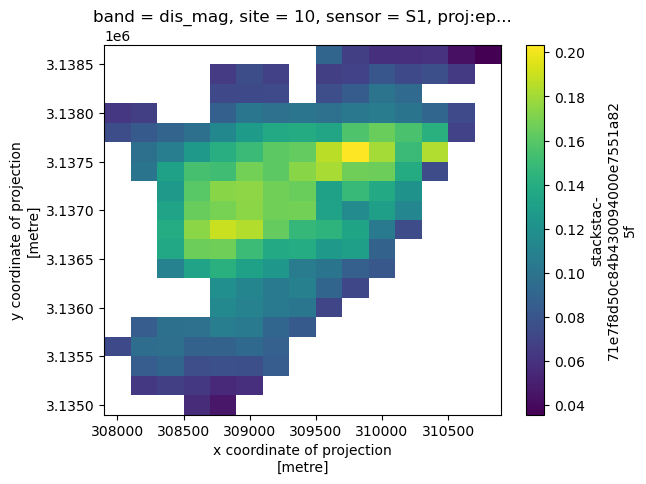

In [38]:
cube_03976.sel(band='dis_mag').mean(dim='time').plot()

In [43]:
cube_03976.sel(band='dis_mag').isel(time=20).mean().compute()

<xarray.DataArray 'stackstac-71e7f8d50c84b430094000e7551a825f' ()>
array(0.27154046)
Coordinates: (12/16)
    time         datetime64[ns] 2015-03-16
    id           <U19 '10_085_005_20150316'
    band         <U9 'dis_mag'
    acq_id       <U4 '8D06'
    tile         <U10 '10_085_005'
    acq_date     <U15 '20150304T122149'
    ...           ...
    site         <U2 '10'
    sensor       <U2 'S1'
    proj:epsg    int64 32645
    title        <U9 'dis_mag'
    epsg         int64 32645
    spatial_ref  int64 0

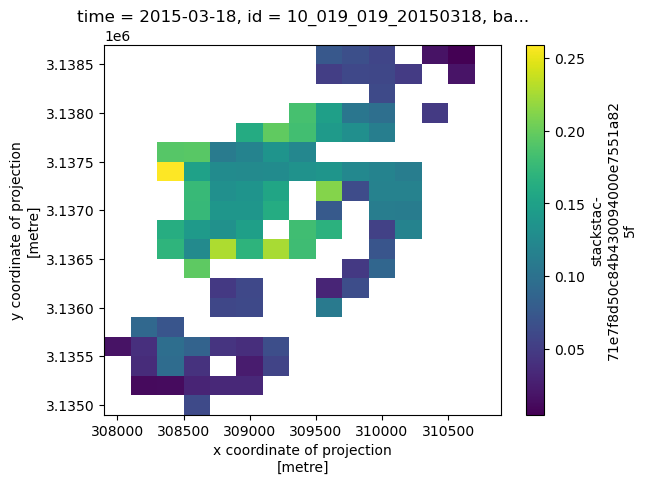

In [41]:
cube_03976.sel(band='dis_mag').isel(time=21).plot()